In [1]:
import os
import requests

import numpy as np
import pandas as pd

from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch
from torch.utils.data import DataLoader

from OrnsteinUhlenbeck.n_standart_ou import VasicekModel, mle_ou

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
dt = 0.01
t = np.arange(0, 1000, dt)

In [5]:
q = {"s_0": 0.0, "kappa": 0.05, "theta": 2.0, "sigma": 0.5}

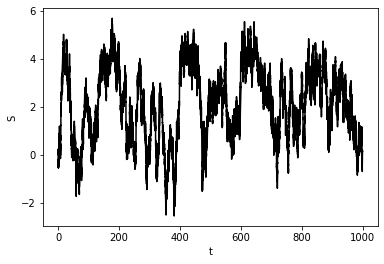

In [6]:
ou = VasicekModel(**q)
x = ou.path(t)

plt.xlabel("t")
plt.ylabel("S")
plt.plot(t, x, color="black")

In [7]:
train_size = int(len(x) * 0.66)

#LSTM preprocess
X = [[v] for v in x]

# Vasicek preprocess
v_train, v_test = list(x[:train_size]), x[train_size:]

In [8]:
result = mle_ou(t[:train_size], v_train)
kappa = result.params["kappa"].value
theta = result.params["theta"].value
sigma = result.params["sigma"].value
q_predicted = {"kappa": kappa, "theta": theta, "sigma": sigma}
print(q_predicted)

{'kappa': 0.04536923785247671, 'theta': 2.074085971390277, 'sigma': 0.5010502984401076}


In [20]:
np.random.seed(2)

def predict(s_t, kappa, theta, sigma):
    return s_t + kappa * (theta - s_t) * dt + sigma * np.sqrt(dt) * np.random.normal()

In [21]:
v_train[-1]

3.246189304997519

In [22]:
predict(v_train[-1], **q_predicted)

3.224775866266241

Test MSE: 0.005006


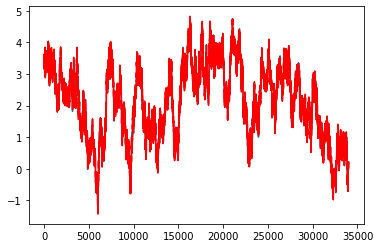

In [23]:
predictions = [predict(v_train[-1], **q_predicted)]

for s in v_test[:-1]:
    predictions.append(predict(s, **q_predicted))

    
error = mean_squared_error(v_test, predictions)
print('Test MSE: %.6f' % error)

# plot
plt.plot(v_test)
plt.plot(predictions, color='red')
plt.show()

In [13]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm_1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                              batch_first=True)
        self.lstm_2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                              dropout=0.2, batch_first=True)
        self.lstm_3 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                              dropout=0.2, batch_first=True)
        
        self.fc = nn.ReLU()

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        
        output, (hn, cn) = self.lstm_1(x, (h_0, c_0))
        output, (hn, cn) = self.lstm_2(output, (hn, cn))
        output, (hn, cn) = self.lstm_3(output, (hn, cn))
        hn = hn.view(-1, self.hidden_size)
        
        out = self.fc(hn)
        return out

In [14]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm_1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                              batch_first=True)
        self.lstm_2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                              batch_first=True)
        self.lstm_3 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                              batch_first=True)
        
        self.relu = nn.ReLU()
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        
        output, (hn, cn) = self.lstm_1(x, (h_0, c_0))
        output, (hn, cn) = self.lstm_2(output, (hn, cn))
        output, (hn, cn) = self.lstm_3(output, (hn, cn))
        hn = hn.view(-1, self.hidden_size)
        
        out = self.relu(hn)
        out = self.fc(out)
        
        return out

In [15]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [16]:
seq_length = 50

lstm_x, lstm_y = sliding_windows(X, seq_length)

test_size = len(lstm_y) - train_size

trainX = torch.Tensor(np.array(lstm_x[0:train_size]))
trainY = torch.Tensor(np.array(lstm_y[0:train_size]))

testX = torch.Tensor(np.array(lstm_x[train_size:len(lstm_x)]))
testY = torch.Tensor(np.array(lstm_y[train_size:len(lstm_y)]))

In [17]:
dataloaderX = DataLoader(trainX, batch_size=20000, shuffle=False)
dataloaderY = DataLoader(trainY, batch_size=20000, shuffle=False)
test_dataloaderX = DataLoader(testX, batch_size=20000, shuffle=False)
test_dataloaderY = DataLoader(testY, batch_size=20000, shuffle=False)

In [18]:
num_epochs = 1000
learning_rate = 0.001

input_size = 1
hidden_size = 50
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for batch_ind, (x_batch, y_batch) in enumerate(zip(dataloaderX, dataloaderY)):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = lstm(x_batch)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
#         print(f"Epoch: {epoch}, Batch: {batch_ind} loss: {loss.item()}")
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Batch: {batch_ind} loss: {loss.item()}")

Epoch: 0, Batch: 3 loss: 17.8048152923584
Epoch: 10, Batch: 3 loss: 4.669168949127197
Epoch: 20, Batch: 3 loss: 1.991152286529541
Epoch: 30, Batch: 3 loss: 0.8681685924530029
Epoch: 40, Batch: 3 loss: 0.4330926835536957
Epoch: 50, Batch: 3 loss: 0.24355089664459229
Epoch: 60, Batch: 3 loss: 0.18296000361442566
Epoch: 70, Batch: 3 loss: 0.11222193390130997
Epoch: 80, Batch: 3 loss: 0.0859709233045578
Epoch: 90, Batch: 3 loss: 0.07275092601776123
Epoch: 100, Batch: 3 loss: 0.05756860226392746
Epoch: 110, Batch: 3 loss: 0.046363428235054016
Epoch: 120, Batch: 3 loss: 0.0497528575360775
Epoch: 130, Batch: 3 loss: 0.03625600039958954
Epoch: 140, Batch: 3 loss: 0.028769243508577347
Epoch: 150, Batch: 3 loss: 0.0312160886824131
Epoch: 160, Batch: 3 loss: 0.03883326053619385
Epoch: 170, Batch: 3 loss: 0.021011855453252792
Epoch: 180, Batch: 3 loss: 0.01917514018714428
Epoch: 190, Batch: 3 loss: 0.02197815477848053
Epoch: 200, Batch: 3 loss: 0.03564652055501938
Epoch: 210, Batch: 3 loss: 0.0158

Test MSE: 0.005259


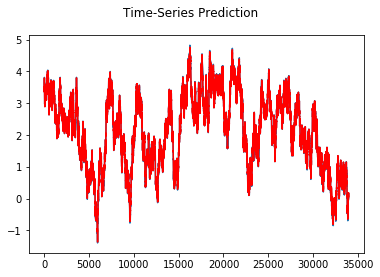

In [19]:
lstm.eval()

testX = testX.to(device)

error = 0
predictions = []
for batch_ind, (x_batch, y_batch) in enumerate(zip(test_dataloaderX, test_dataloaderY)):
    x_batch = x_batch.to(device)

    outputs = lstm(x_batch).cpu().detach().numpy()
    
    predictions.extend(outputs)
    error += mean_squared_error(y_batch, outputs)
    
print('Test MSE: %.6f' % error)


plt.plot(testY)
plt.plot(predictions, color='red')
plt.suptitle('Time-Series Prediction')
plt.show()